In [1]:
## Import Dependencies

from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as dt
import time

import numpy as np
import scipy.stats as stats
import math

In [2]:
#Read in the power data for DP&L
df = pd.read_csv('DPL_Hourly_Consumption.csv',parse_dates =['Datetime'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
Datetime     121275 non-null datetime64[ns]
DAYTON_MW    121275 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


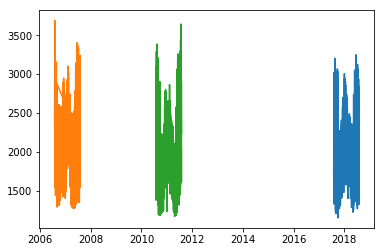

In [4]:
## some simple plots to visualize the data

x = df[(df.Datetime> "2017-08-01") & (df.Datetime <= '2018-08-01')].Datetime
y = df[(df.Datetime> "2017-08-01") & (df.Datetime <= '2018-08-01')].DAYTON_MW
x2 = df[(df.Datetime> "2006-08-01") & (df.Datetime <= '2007-08-01')].Datetime
y2 = df[(df.Datetime> "2006-08-01") & (df.Datetime <= '2007-08-01')].DAYTON_MW
x3 = df[(df.Datetime> "2010-08-01") & (df.Datetime <= '2011-08-01')].Datetime
y3 = df[(df.Datetime> "2010-08-01") & (df.Datetime <= '2011-08-01')].DAYTON_MW
plt.plot(x,y)
plt.plot(x2,y2)
plt.plot(x3,y3)

plt.show()



In [5]:
# Read in Weather Data

Wd = pd.read_json("weather_data_json_dayton_bulkText.json")

In [6]:
Wd.head()
Wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42169 entries, 0 to 42168
Data columns (total 9 columns):
city_id    42169 non-null int64
clouds     42169 non-null object
dt         42169 non-null int64
dt_iso     42169 non-null object
main       42169 non-null object
rain       6327 non-null object
snow       46 non-null object
weather    42169 non-null object
wind       42169 non-null object
dtypes: int64(2), object(7)
memory usage: 2.9+ MB


In [7]:
## Cleaner way to pull this in as datetime.. create column and use the lambda to get rid of the extra UTC datetime data
Wd['Date_Clean'] = (Wd['dt_iso'].apply(lambda x: x[:19])
                    .apply(lambda x : dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
                   )

In [8]:
# because we are going to make use of the dates in our analysis .. rows for month year, day, day of week, and weekend are created. 

Wd2 = Wd.assign(year = Wd['Date_Clean'].dt.year,
         month = Wd['Date_Clean'].dt.month,
         day = Wd['Date_Clean'].dt.day,
         day_of_week = Wd['Date_Clean'].dt.weekday,
         weekend = Wd['Date_Clean'].dt.weekday.apply(lambda x : 1 if x > 4 else 0)).copy()
Wd2.head()

,city_id,clouds,dt,dt_iso,main,rain,snow,weather,wind,Date_Clean,year,month,day,day_of_week,weekend
0,4509884,{'all': 75},1349096400,2012-10-01 13:00:00 +0000 UTC,"{'temp': 284.02, 'temp_min': 282.15, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 2, 'deg': 30}",2012-10-01 13:00:00,2012,10,1,0,0
1,4509884,{'all': 75},1349100000,2012-10-01 14:00:00 +0000 UTC,"{'temp': 285.83, 'temp_min': 284.26, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 2, 'deg': 50}",2012-10-01 14:00:00,2012,10,1,0,0
2,4509884,{'all': 75},1349190000,2012-10-02 15:00:00 +0000 UTC,"{'temp': 287.44, 'temp_min': 286.48, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 3, 'deg': 90}",2012-10-02 15:00:00,2012,10,2,1,0
3,4509884,{'all': 1},1349193600,2012-10-02 16:00:00 +0000 UTC,"{'temp': 288.31, 'temp_min': 287.15, 'temp_max...",NaN,NaN,"[{'id': 800, 'main': 'Clear', 'description': '...","{'speed': 3, 'deg': 70}",2012-10-02 16:00:00,2012,10,2,1,0
4,4509884,{'all': 40},1349197200,2012-10-02 17:00:00 +0000 UTC,"{'temp': 289.5, 'temp_min': 288.71, 'temp_max'...",NaN,NaN,"[{'id': 802, 'main': 'Clouds', 'description': ...","{'speed': 4, 'deg': 80}",2012-10-02 17:00:00,2012,10,2,1,0


In [9]:
# We have some conversions to do as some of the columns are dicts, and units are not suitable

Temp = []
Humidity = []
Wind = []
Date_Time = []
Rain = []
Month = []
Snow = []
Year = []
Day = []
Day_of_Week = []
Weekend = []

for i in range(0,len(Wd2)):
    #Convert to Fahrenheit
    t = round(((Wd2.main[i]['temp_max']-273.15)*9/5)+32,2)
    h = Wd2.main[i]['humidity']
    #Convert to MPH
    w = round(Wd2.wind[i]['speed']*2.26394,2)
    d = Wd2['Date_Clean'][i]
    r = Wd2.rain[i]
    s = Wd2.snow[i]
    m = Wd2.month[i]
    y = Wd2.year[i]
    dy = Wd2.day[i]
    dow =Wd2.day_of_week[i]
    wknd = Wd2.weekend[i]
    Rain.append(r)
    Snow.append(s)
    Date_Time.append(d)
    Wind.append(w)
    Humidity.append(h)
    Temp.append(t)
    Month.append(m)
    Year.append(y)
    Day.append(dy)
    Day_of_Week.append(dow)
    Weekend.append(wknd)

    
# now we have a group of lists 


In [10]:
#Next build dictionary to reassemble our DF
Wd_dict = {'City':"Dayton,OH",'Datetime':Date_Time,"Year":Year,'Month':Month,'Day':Day,'Day_of_Week':Day_of_Week,'Weekend':Weekend,'Temperature(F)':Temp,
          'Humidity':Humidity,'Wind Speed(mph)':Wind,'Rain Volume':Rain,'Snow Volume':Snow,}
Wd_df = pd.DataFrame(Wd_dict)

In [12]:
Wd_df.head()


,City,Datetime,Year,Month,Day,Day_of_Week,Weekend,Temperature(F),Humidity,Wind Speed(mph),Rain Volume,Snow Volume
0,"Dayton,OH",2012-10-01 13:00:00,2012,10,1,0,0,54.00,81,4.53,NaN,NaN
1,"Dayton,OH",2012-10-01 14:00:00,2012,10,1,0,0,57.99,76,4.53,NaN,NaN
2,"Dayton,OH",2012-10-02 15:00:00,2012,10,2,1,0,59.00,62,6.79,NaN,NaN
3,"Dayton,OH",2012-10-02 16:00:00,2012,10,2,1,0,62.01,77,6.79,NaN,NaN
4,"Dayton,OH",2012-10-02 17:00:00,2012,10,2,1,0,63.00,72,9.06,NaN,NaN


In [13]:
## calling info we confirm we have a datetime object for Datetime
Wd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42169 entries, 0 to 42168
Data columns (total 12 columns):
City               42169 non-null object
Datetime           42169 non-null datetime64[ns]
Year               42169 non-null int64
Month              42169 non-null int64
Day                42169 non-null int64
Day_of_Week        42169 non-null int64
Weekend            42169 non-null int64
Temperature(F)     42169 non-null float64
Humidity           42169 non-null int64
Wind Speed(mph)    42169 non-null float64
Rain Volume        6327 non-null object
Snow Volume        46 non-null object
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 3.9+ MB


In [14]:
## ok now ready we agreed to use more recent data for our dataset so will grab data from May1 of 2016 thru April 30 2018.
df.Datetime.head(24)

df_2 = df[(df.Datetime>='2016-05-01 00:00:00') & (df.Datetime< '2018-05-01 00:00:00')].copy()
df_2.set_index('Datetime',inplace = True)
df_2



,DAYTON_MW
Datetime,
2016-12-31 01:00:00,1788
2016-12-31 02:00:00,1730
2016-12-31 03:00:00,1701
2016-12-31 04:00:00,1693
2016-12-31 05:00:00,1708
2016-12-31 06:00:00,1732
2016-12-31 07:00:00,1778
2016-12-31 08:00:00,1849
2016-12-31 09:00:00,1877


In [15]:
## lets take a look at the len
len(df_2)


17520

In [16]:
## so the Weather Df we create should be of the same length

Wd_df_2 = Wd_df[(Wd_df.Datetime>='2016-05-01 00:00:00') & (Wd_df.Datetime< '2018-05-01 00:00:00')].copy()
Wd_df_2.set_index('Datetime',inplace = True)
Wd_df_2.head()

,City,Year,Month,Day,Day_of_Week,Weekend,Temperature(F),Humidity,Wind Speed(mph),Rain Volume,Snow Volume
Datetime,,,,,,,,,,,
2016-05-01 00:00:00,"Dayton,OH",2016,5,1,6,1,59.0,100,4.53,{'1h': 1.1},NaN
2016-05-01 01:00:00,"Dayton,OH",2016,5,1,6,1,59.0,100,9.06,{'1h': 0.76},NaN
2016-05-01 02:00:00,"Dayton,OH",2016,5,1,6,1,59.0,87,9.06,{'1h': 0.51},NaN
2016-05-01 03:00:00,"Dayton,OH",2016,5,1,6,1,59.0,93,9.06,{'1h': 0.25},NaN
2016-05-01 04:00:00,"Dayton,OH",2016,5,1,6,1,60.8,100,4.53,{'1h': 0.25},NaN


In [17]:
### so it seems we have some missing values in the weather data this will mean some times 76 hours where we will not get a 
## match on the join.

combined_df = df_2.join(Wd_df_2,how = 'left')
combined_df.drop(index = combined_df[combined_df.City.isna()].index.values,inplace = True)
combined_df.head()

,DAYTON_MW,City,Year,Month,Day,Day_of_Week,Weekend,Temperature(F),Humidity,Wind Speed(mph),Rain Volume,Snow Volume
Datetime,,,,,,,,,,,,
2016-05-01 00:00:00,1473,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.0,100.0,4.53,{'1h': 1.1},NaN
2016-05-01 01:00:00,1392,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.0,100.0,9.06,{'1h': 0.76},NaN
2016-05-01 02:00:00,1337,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.0,87.0,9.06,{'1h': 0.51},NaN
2016-05-01 03:00:00,1301,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.0,93.0,9.06,{'1h': 0.25},NaN
2016-05-01 04:00:00,1273,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,60.8,100.0,4.53,{'1h': 0.25},NaN


In [ ]:
combined_df[combined_df.Year==2017 ]["Temperature(F)"]

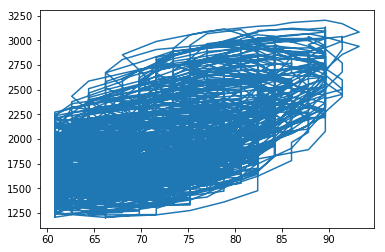

1818.355195774163

In [18]:
x= combined_df[(combined_df["Temperature(F)"]> 60)&(combined_df.Year == 2017)]['Temperature(F)']
y= combined_df[(combined_df["Temperature(F)"]>60)&(combined_df.Year == 2017)]['DAYTON_MW']
x2 =combined_df.iloc[150:]['Humidity']
plt.plot(x,y)

plt.show()
Covar = np.cov(x.values,y.values)[0,1]
#x.values
Covar

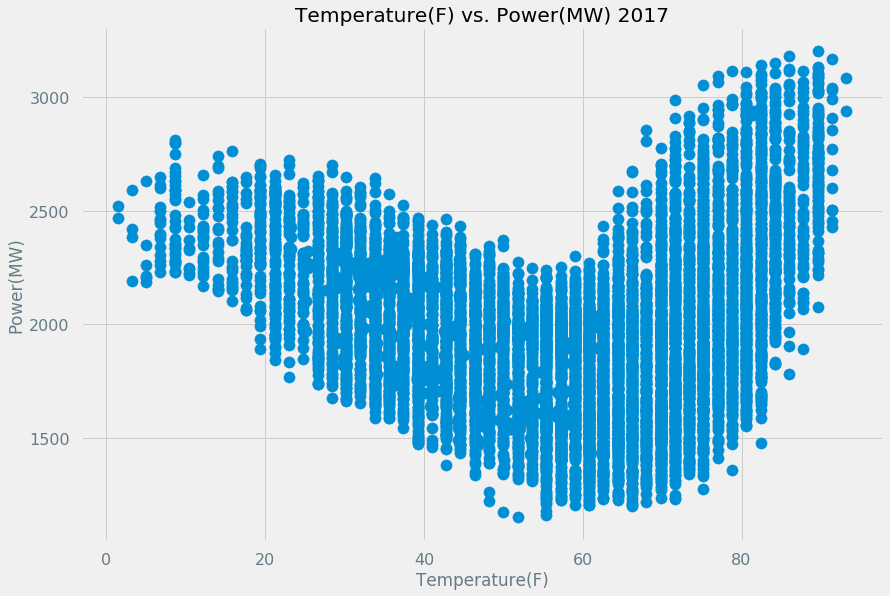

In [71]:
x= combined_df[combined_df.Year == 2017]['Temperature(F)']
y= combined_df[combined_df.Year == 2017]['DAYTON_MW']
                
plt.scatter(x,y)
plt.xlabel("Temperature(F)")
plt.ylabel("Power(MW)")
plt.title('Temperature(F) vs. Power(MW) 2017')
plt.savefig("Temp_Power_2017.png")
plt.show()
            

In [20]:
x.values.std()
y.values.std()
correl = round(Covar/(x.values.std()*y.values.std()),2)
correl


0.28

In [61]:

First_Week_df = combined_df[(combined_df.index >= '2017-07-01') & (combined_df.index < '2017-07-07')]
June = combined_df
FWmean = round(First_Week_df['Temperature(F)'].mean(),2)
FWstd = round(First_Week_df["Temperature(F)"].std(),2)
FWsem = round(First_Week_df["Temperature(F)"].sem(),2)
FWsem
First_Week_df['DAYTON_MW'].mean()
First_Week_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2017-07-01 00:00:00 to 2017-07-06 23:00:00
Data columns (total 12 columns):
DAYTON_MW          140 non-null int64
City               140 non-null object
Year               140 non-null float64
Month              140 non-null float64
Day                140 non-null float64
Day_of_Week        140 non-null float64
Weekend            140 non-null float64
Temperature(F)     140 non-null float64
Humidity           140 non-null float64
Wind Speed(mph)    140 non-null float64
Rain Volume        0 non-null object
Snow Volume        0 non-null object
dtypes: float64(8), int64(1), object(3)
memory usage: 14.2+ KB


In [62]:
y.mean()/y2.mean()


1.0862569478281974

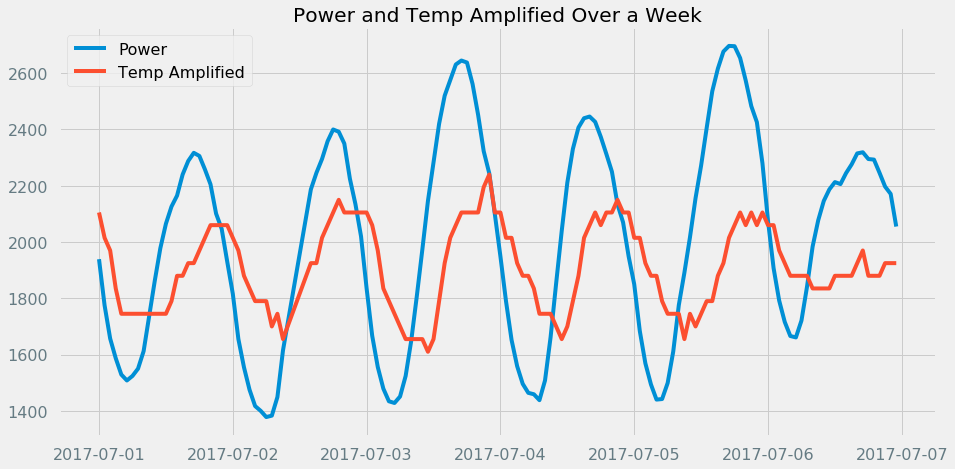

In [72]:
plt.figure(figsize=[14,7])


x = First_Week_df.index   #['Temperature(F)']
y = First_Week_df["DAYTON_MW"]
y2 = First_Week_df['Temperature(F)']*25
#plt.xlim("2016-05-01","2016-05-08")
plt.plot(x,y,label = "Power")
plt.plot(x,y2,label = "Temp Amplified")
plt.title("Power and Temp Amplified Over a Week")
plt.legend()
plt.savefig("Power_Temp_Amped.png")
plt.show()



In [54]:
plt.style.available


['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

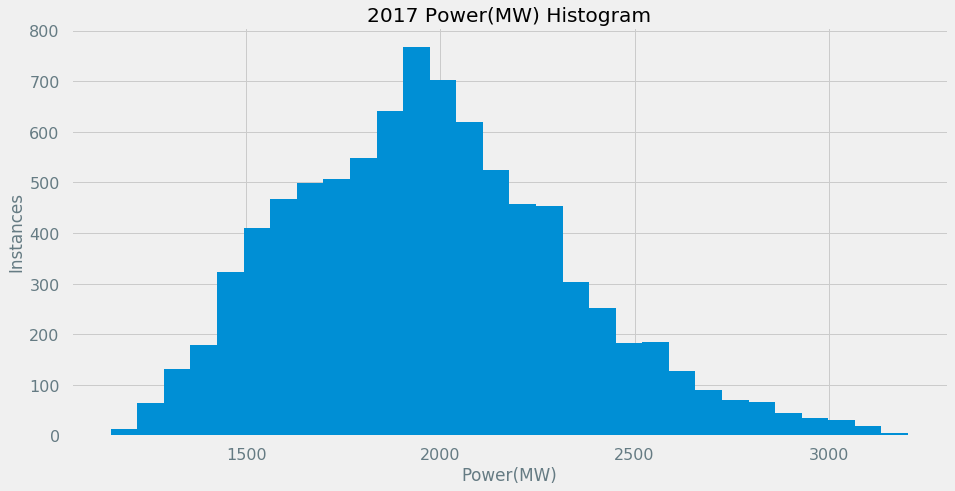

In [73]:
plt.style.use( 'fivethirtyeight')
plt.figure(figsize= [14,7])

x = combined_df[combined_df.Year == 2017]["DAYTON_MW"]

plt.hist(x,bins = 30,histtype = 'stepfilled')
plt.xlabel("Power(MW)")
plt.ylabel("Instances")
plt.title("2017 Power(MW) Histogram")
plt.savefig("Power_Hist.png")
plt.show()

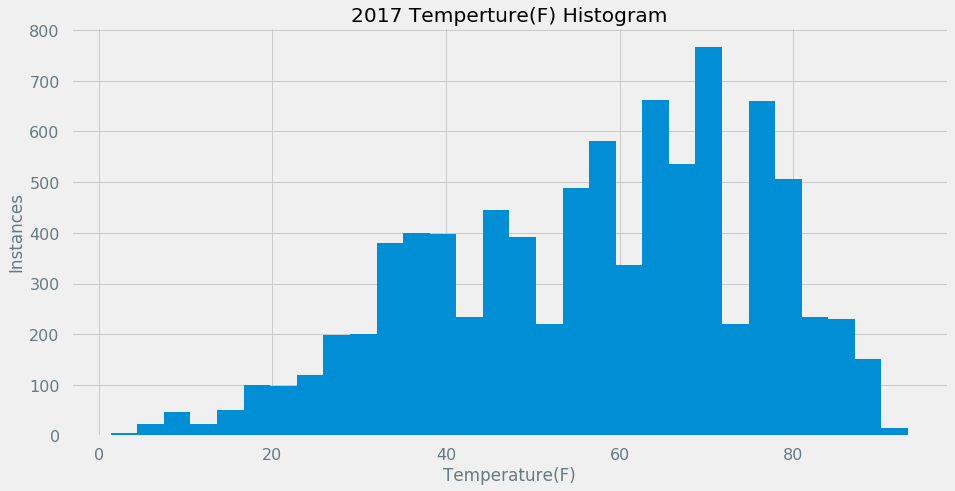

In [74]:
plt.figure(figsize= [14,7])

x = combined_df[combined_df.Year== 2017]["Temperature(F)"]

plt.hist(x,bins = 30)
plt.xlabel("Temperature(F)")
plt.ylabel("Instances")
plt.title("2017 Temperture(F) Histogram")
plt.savefig("Temp_Hist.png")
plt.show()

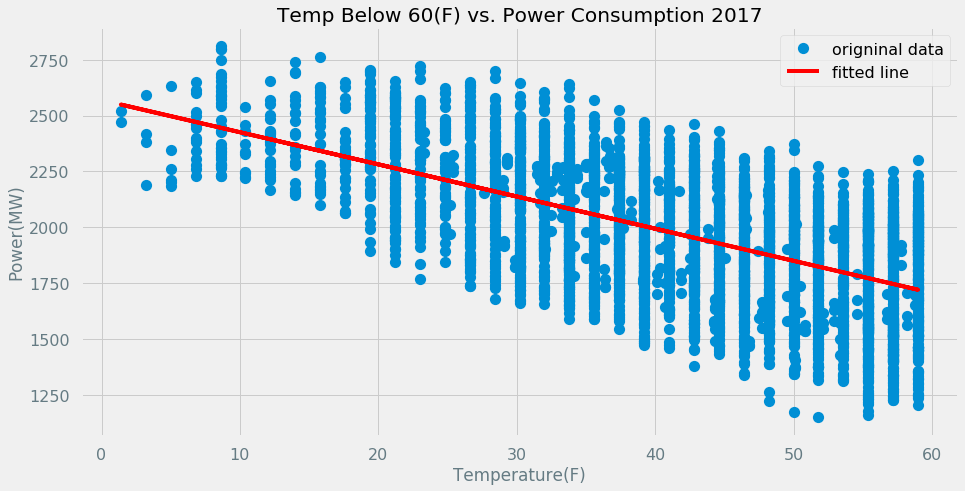

In [82]:
plt.figure(figsize = (14,7))

x= combined_df[(combined_df["Temperature(F)"]< 60)&(combined_df.Year == 2017)]['Temperature(F)']
y= combined_df[(combined_df["Temperature(F)"]<60)&(combined_df.Year == 2017)]['DAYTON_MW']
stats.linregress(x,y)
plt.plot(x,y,'o',label = "origninal data")
plt.plot(x, stats.linregress(x,y).intercept + stats.linregress(x,y).slope*x, 'r', label='fitted line')
plt.xlabel("Temperature(F)")
plt.ylabel("Power(MW)")
plt.title("Temp Below 60(F) vs. Power Consumption 2017")
plt.savefig("Temp_under_60_linregress.png")
plt.legend()
plt.show()


In [68]:
stats.linregress(x,y)

LinregressResult(slope=-14.389642640685963, intercept=2569.6748309438135, rvalue=-0.5995904339690555, pvalue=0.0, stderr=0.2895513514833273)

In [83]:
np.corrcoef(x,y)[0,1]

-0.5995904339690556

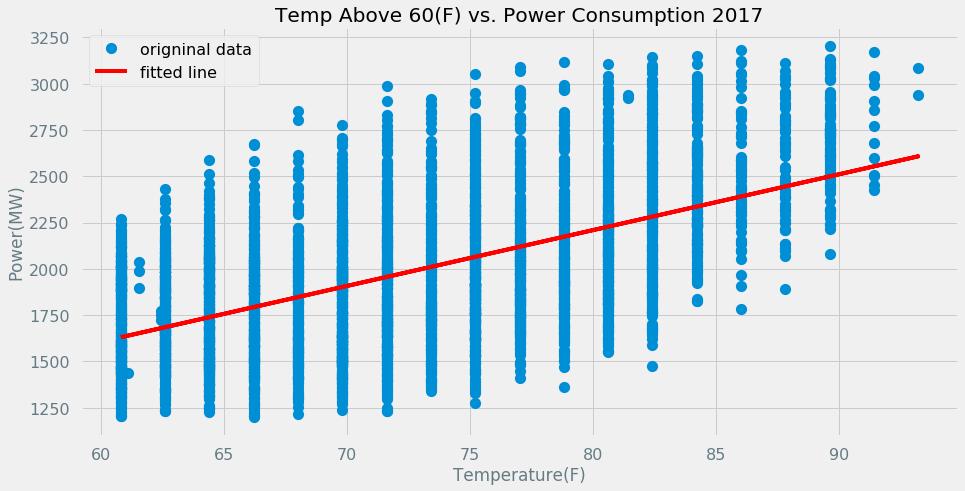

In [76]:
plt.figure(figsize = (14,7))

x= combined_df[(combined_df["Temperature(F)"]> 60)&(combined_df.Year == 2017)]['Temperature(F)']
y= combined_df[(combined_df["Temperature(F)"]>60)&(combined_df.Year == 2017)]['DAYTON_MW']
stats.linregress(x,y)
plt.plot(x,y,'o',label = "origninal data")
plt.plot(x, stats.linregress(x,y).intercept + stats.linregress(x,y).slope*x, 'r', label='fitted line')
plt.xlabel("Temperature(F)")
plt.ylabel("Power(MW)")
plt.title("Temp Above 60(F) vs. Power Consumption 2017")
plt.savefig("Temp_over_60_linregres.png")
plt.legend()
plt.show()

In [70]:
stats.linregress(x,y)

LinregressResult(slope=30.152200042584933, intercept=-202.40788323442484, rvalue=0.5710463228350132, pvalue=0.0, stderr=0.6596385681034164)

In [81]:
np.corrcoef(x,y)[0,1]

0.5710463228350132